In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, Image, display
from sklearn.base import BaseEstimator, clone
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


def display_markdown(markdown: str) -> None:
    """Display markdown on the output

    Args:
        markdown (str): markdown data string
    """
    display(Markdown(markdown))


def display_image(filepath: str) -> None:
    """Approach for draw an image in Python Interactive window and for notebook
    I tired to fight against images outputs bugs, and just use python to fix

    Args:
        filepath (str): image path
    """
    display(Image(filename=filepath))

# Classification
## MNIST
> By default Scikit-Learn caches downloaded datasets
in a directory called `$HOME/scikit_learn_data`.

In [2]:
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* A `DESCR` key describing the dataset
* A `data` key containing an array with one row per instance and one column per feature
* A `target` key containing an array with the labels

In [3]:
display_markdown(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.  

With some classification methods (particularly template-based methods, such as SVM and K-nearest neighbors), the error rate improves when the digits are centered by bounding box rather than center of mass. If you do this kind of pre-processing, you should report it in your publications. The MNIST database was constructed from NIST's NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. The reason for this can be found on the fact that SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students. Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of training set and test among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets.  

The MNIST training set is composed of 30,000 patterns from SD-3 and 30,000 patterns from SD-1. Our test set was composed of 5,000 patterns from SD-3 and 5,000 patterns from SD-1. The 60,000 pattern training set contained examples from approximately 250 writers. We made sure that the sets of writers of the training set and test set were disjoint. SD-1 contains 58,527 digit images written by 500 different writers. In contrast to SD-3, where blocks of data from each writer appeared in sequence, the data in SD-1 is scrambled. Writer identities for SD-1 is available and we used this information to unscramble the writers. We then split SD-1 in two: characters written by the first 250 writers went into our new training set. The remaining 250 writers were placed in our test set. Thus we had two sets with nearly 30,000 examples each. The new training set was completed with enough examples from SD-3, starting at pattern # 0, to make a full set of 60,000 training patterns. Similarly, the new test set was completed with SD-3 examples starting at pattern # 35,000 to make a full set with 60,000 test patterns. Only a subset of 10,000 test images (5,000 from SD-1 and 5,000 from SD-3) is available on this site. The full 60,000 sample training set is available.

Downloaded from openml.org.

In [4]:
X, y = mnist.data, mnist.target

X.shape, y.shape

((70000, 784), (70000,))

There are 70,000 images, and each image has 784 features. This is because each image
is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to
do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using
Matplotlib’s `imshow()` function:

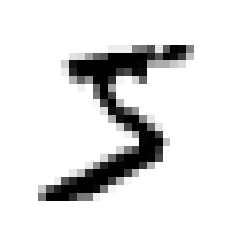

In [5]:
some_digit = X[0]

some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")

plt.axis("off")
plt.show(block=True)

In [6]:
y[0]

'5'

In [7]:
y = y.astype(np.uint8)
y[0]

5

### Several images from dataset

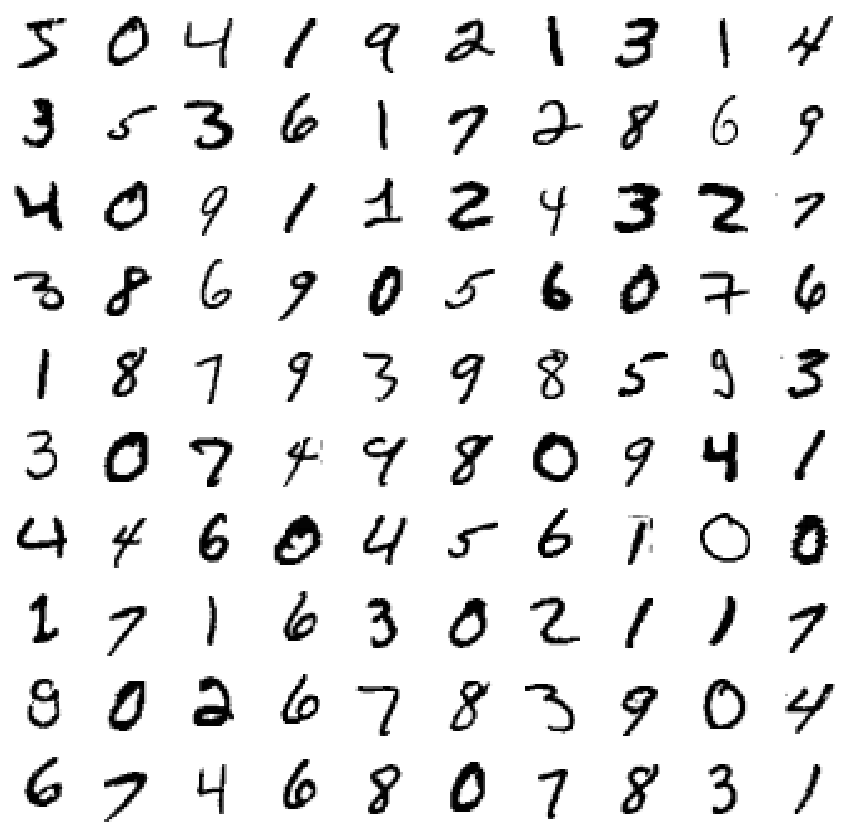

In [8]:
size = 10

fig, axis = plt.subplots(size, size, figsize=(15, 15), facecolor='white')

for i in range(size):
    for j in range(size):
        shift = i * size
        some_digit = X[shift + j]
        some_digit_image = some_digit.reshape(28, 28)
        ax = axis[i][j]
        ax.imshow(some_digit_image, cmap=mpl.cm.binary,
                  interpolation="nearest")
        ax.axis("off")

plt.show(block=True)

But wait! You should always create a test set and set it aside before inspecting the data
closely. The MNIST dataset is actually already split into a training set
(the first 60000 images) and a test set (the last 10,000 images):

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
### Setup array of 5 in labels

In [10]:
y_train_5 = y_train == 5  # True for all 5s, False for all other digits.
y_test_5 = y_test == 5
y_train_5[:5]

array([ True, False, False, False, False])

In [11]:
y_test_5[5:10]

array([False, False, False,  True, False])

Okay, now let’s pick a classifier and train it. A good place to start is with a
Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s `SGDClassifier` class.
This classifier has the advantage of being capable of handling very large datasets
efficiently. This is in part because SGD deals with training instances independently,
one at a time (which also makes SGD well suited for online learning), as we will see later.
Let’s create an `SGDClassifier` and train it on the whole training set

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

> The `SGDClassifier` relies on randomness during training (hence
the name “stochastic”). If you want reproducible results, you
should set the `random_state` parameter.
#### Problem with first digit, probably difference between my laptop and author env

In [13]:
sgd_clf.predict([some_digit])

array([False])

#### But for 11's item it works fine

In [14]:
sgd_clf.predict([X[11]])

array([ True])

## Performance Measures
### Measuring Accuracy Using Cross-Validation

In [15]:
skfolds = StratifiedKFold(n_splits=3, shuffle=False)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)

    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_predict = clone_clf.predict(X_test_folds)
    n_correct = sum(y_predict == y_test_folds)

    print(n_correct / len(y_predict))

0.95035
0.96035
0.9604


The `StratifiedKFold` class performs stratified sampling (as explained in Chapter 2)
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions
Let’s use the `cross_val_score()` function to evaluate your `SGDClassifier` model
using K-fold cross-validation, with three folds. Remember that K-fold cross-validation
means splitting the training set into K-folds (in this case, three), then making
predictions and evaluating them on each fold using a model trained on the remaining folds

In [16]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

#### very dumb classifier that just classifies every single image in the “not-5” class

In [17]:
class Never5Classifier(BaseEstimator):
    """Dummy class that never detect 5

    Args:
        BaseEstimator ([BaseEstimator]): base estimator parent class
    """

    def fit(self, X: np.ndarray, y: np.ndarray = None) -> None:
        """Fit function that do nothing

        Args:
            X (np.ndarray): values for training that need to fit
            y (np.ndarray, optional): values for prediction test. Defaults to None.
        """
        pass

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predictor method

        Args:
            X (np.ndarray): Data for predictor

        Returns:
            np.ndarray: Prediction result data
        """
        return np.zeros((len(X), 1), dtype=bool)


never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

> That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. Beats Nostradamus.

### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confusion matrix.
The general idea is to count the number of times instances of class A are classified as class B.
For example, to know the number of times the classifier confused images of 5s with 3s, you would
look in the $5^{th}$ row and $3^{rd}$ column of the confusion matrix.
To compute the confusion matrix, you first need to have a set of predictions, so they can be
compared to the actual targets. You could make predictions on the test set, but let’s keep it
untouched for now (remember that you want to use the test set only at the very end of your project,
once you have a classifier that you are ready to launch).
Instead, you can use the `cross_val_predict()` function:

In [18]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now you are ready to get the confusion matrix using the `confusion_matrix()` function. Just pass it the target classes (`y_train_5`) and the predicted classes (`y_train_pred`)

In [19]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a
predicted class. The first row of this matrix considers non-5 images (the negative class):
53,057 of them were correctly classified as non-5s (they are called true negatives),
while the remaining 1,522 were wrongly classified as 5s (false positives). The second row
considers the images of 5s (the positive class): 1,325 were wrongly classified as non-5s
(false negatives), while the remaining 4,096 were correctly classified as 5s (true positives).
A perfect classifier would have only true positives and true negatives, so its confusion
matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [20]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

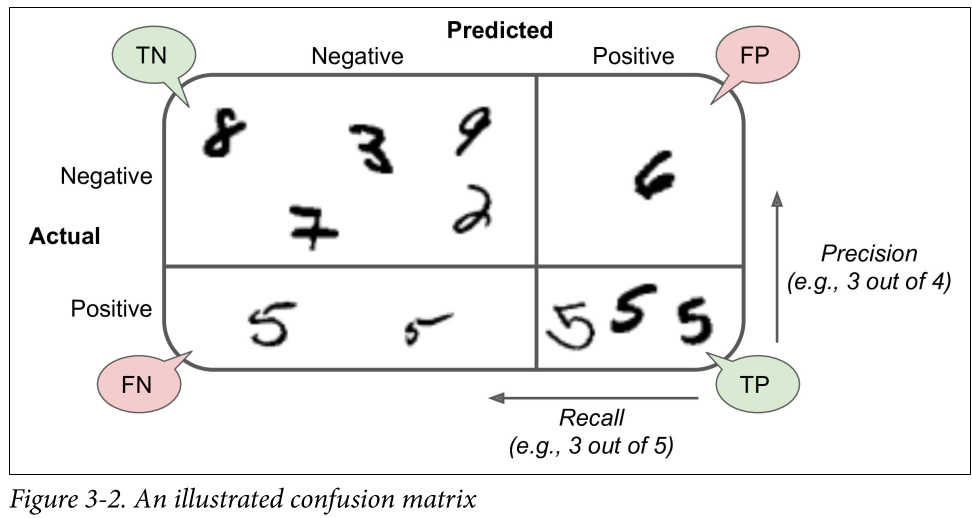

In [21]:
display_image("./assets/2022-01-31-18-06-10.png")

`TP` is the number of true positives, and `FP` is the number of false positives.
A trivial way to have perfect precision is to make one single positive
prediction and ensure it is correct (precision = 1/1 = 100%).
This would not be very useful since the classifier would ignore all but one
positive instance. So precision is typically used along with another metric named
recall, also called sensitivity or true positive rate (`TPR`): this is the ratio
of positive instances that are correctly detected by the classifier.
`FN` is of course the number of false negatives.

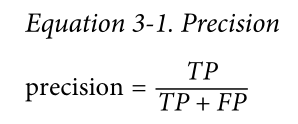

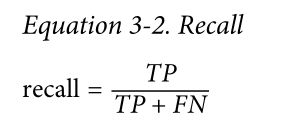

In [22]:
display_image("./assets/2022-01-31-18-33-43.png")
display_image("./assets/2022-01-31-18-35-19.png")

### Precision and Recall
Scikit-Learn provides several functions to compute classifier metrics,
including **precision** and **recall**:

In [23]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

It is often convenient to combine precision and recall into a single
metric called the $F_1$ score

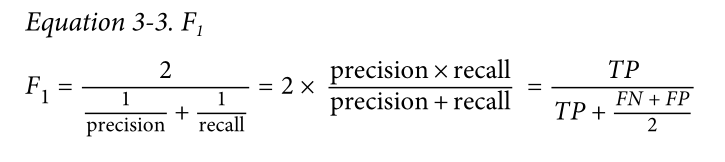

In [25]:
display_image("./assets/2022-01-31-18-40-32.png")

[Harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean)

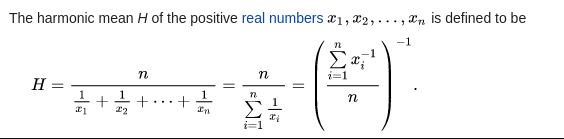

In [26]:
display_image("./assets/2022-01-31-18-42-03.png")

In [27]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

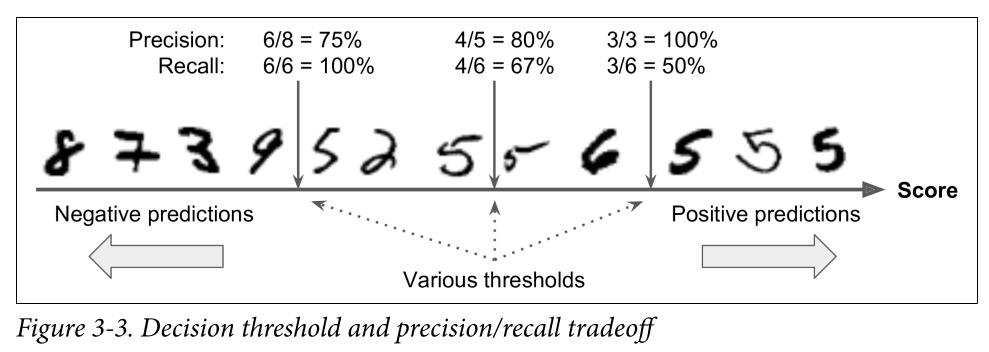

In [28]:
display_image("./assets/2022-01-31-18-45-10.png")

Scikit-Learn does not let you set the threshold directly, but it does give
you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s `predict()` method, you can call its
`decision_function()` method, which returns a score for each instance,
and then make predictions based on those scores using any threshold you want:

In [29]:
y_scores = sgd_clf.decision_function([some_digit])

y_scores = abs(y_scores)

y_scores

array([4125.20277057])

In [30]:
threshold = 0

y_some_digit_pred = y_scores > threshold

y_some_digit_pred

array([ True])

In [31]:
threshold = 8000

y_some_digit_pred = y_scores > threshold

y_some_digit_pred

array([False])

Now how do you decide which threshold to use? For this you will first need to get the
scores of all instances in the training set using the `cross_val_predict()` function
again, but this time specifying that you want it to return decision scores instead of predictions:

In [32]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)

In [33]:
def plot_precision_recall_vs_threshold(
        precisions: np.ndarray,
        recalls: np.ndarray,
        threshold: int) -> None:
    """Plot precision and recall vs threshold

    Args:
        precisions (np.ndarray): precisions data
        recalls (np.ndarray): recalls data
        threshold (int): treshold that we draw on x axe
    """
    # On black background I see nothing, make it contrast
    plt.figure(facecolor='white')
    plt.plot(threshold, precisions[:-1], "b--", label="Precision")
    plt.plot(threshold, recalls[:-1], "g-", label="Recall")
    plt.title("Tresholds")
    plt.grid()
    plt.legend()
    plt.show()

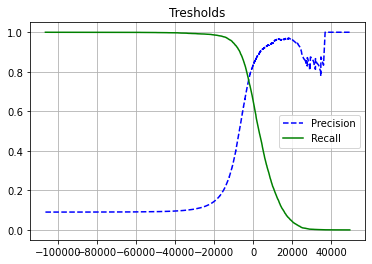

In [34]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

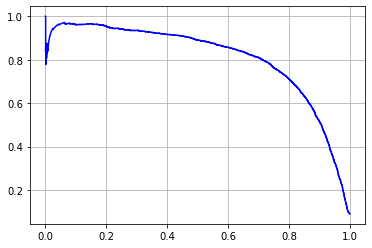

In [35]:
plt.plot(recalls[:-1], precisions[:-1], "b-")
plt.grid()
plt.show()

In [36]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = y_scores >= threshold_90_precision

y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [37]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = y_scores >= threshold_90_precision

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [38]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a
classifier with virtually any precision you want: just set a high enough threshold, and
you’re done. Hmm, not so fast. A high-precision classifier is not very useful if its
recall is too low!
**If someone says “let’s reach 99% precision,” you should ask, “at
what recall?”**

## The ROC Curve
The *receiver operating characteristic* (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of
plotting precision versus recall, the ROC curve plots the *true positive rate* (another name
for recall) against the *false positive rate*. The FPR is the ratio of negative instances that
are incorrectly classified as positive. It is equal to one minus the *true negative rate*,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called *specificity*. Hence the ROC curve plots *sensitivity* (recall) versus
1 – *specificity*.
To plot the ROC curve, you first need to compute the TPR and FPR for various threshold
values, using the `roc_curve()` function:

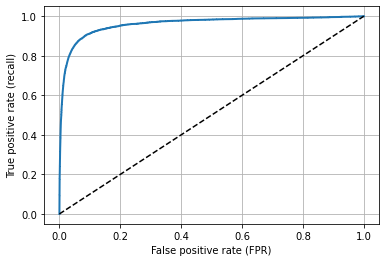

In [39]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


def plot_roc_curve(fpr: np.ndarray, tpr: np.ndarray, label: str = None):
    """Plot receiver operating characteristic (ROG) curve

    Args:
        fpr (np.ndarray): false positive rate
        tpr (np.ndarray): true positive rate (recall)
        label (str, optional): plot label. Defaults to None.
    """
    # On black background I see nothing, make it contrast
    plt.figure(facecolor='white')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
    plt.grid()
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (recall)')


plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).
One way to compare classifiers is to measure the *area under the curve* (AUC).
A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:

In [40]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s train a `RandomForestClassifier` and compare its ROC curve and ROC AUC
score to the `SGDClassifier`. First, you need to get scores for each instance in the
training set. But due to the way it works (see Chapter 7), the `RandomForestClassifier`
class does not have a `decision_function()` method. Instead it has a `predict_proba()`
method. Scikit-Learn classifiers generally have one or the other. The `predict_proba()`
method returns an array containing a row per instance and a column per class, each
containing the probability that the given instance belongs to the given class
(e.g., 70% chance that the image represents a 5):

In [41]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

But to plot a ROC curve, you need scores, not probabilities. A simple solution is to
use the positive class’s probability as the score:

In [42]:
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(
    y_train_5, y_scores_forest)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as
well to see how they compare

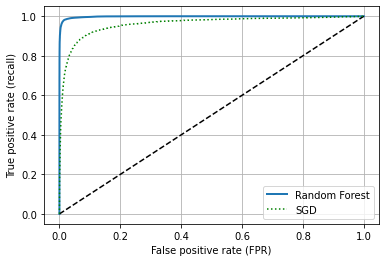

In [43]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr, tpr, "g:", label="SGD")
plt.legend(loc="lower right")
plt.show()

As you can see in plot, the `RandomForestClassifier` ROC curve looks much
better than the `SGDClassifier`: it comes much closer to the top-left corner. As a
result, its ROC AUC score is also significantly better:

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Try measuring the precision and recall scores

In [45]:
y_train_pred_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3)

In [46]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [47]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

Or I can make banary just to setup the treshold and then call scores methods
Should be the same result

In [48]:
y_train_pred_forest_bin = y_scores_forest > 0.7

precision_score(y_train_5, y_train_pred_forest_bin)

0.9976203067160233

In [49]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass Classification
Scikit-Learn detects when you try to use a binary classification algorithm
for a multiclass classification task, and it automatically runs OvA (except
for SVM classifiers for which it uses OvO).
Let’s try this with the `SGDClassifier`

In [50]:
sgd_clf.fit(X_train, y_train)  # y_train, not y_train_5

SGDClassifier(random_state=42)

In [51]:
# Fail to classify, as before
sgd_clf.predict([some_digit]), y[0]

(array([1], dtype=uint8), 5)

#### But for 11's item it should works fine

In [52]:
sgd_clf.predict([X[11]]), y[11]

(array([5], dtype=uint8), 5)

That was easy! This code trains the `SGDClassifier` on the training set using
the original target classes from 0 to 9 (`y_train`), instead of the 5-versus-all
target classes (`y_train_5`). Then it makes a prediction (a correct one in this
case). Under the hood, Scikit-Learn actually trained 10 binary classifiers,
got their decision scores for the image, and selected the class with the
highest score. To see that this is indeed the case, you can call the
`decision_function()` method.
Instead of returning just one score per instance, it now returns 10 scores,
one per class:

In [53]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-24463.25930983,   6295.60574118,  -4167.12075974,
          -926.29807662,  -3460.26911073,  -5590.89861073,
        -20394.704848  ,    614.85001197,  -1439.48933879,
         -4198.45757259]])

The highest score is indeed the one corresponding to class 3, error is still here
Example with match bellow

In [54]:
some_digit_scores2 = sgd_clf.decision_function([X[11]])
some_digit_scores2

array([[-30446.28807622, -20771.5971377 ,  -4069.97324426,
         -7297.18084344,  -2335.35560779,   3839.63697115,
        -27845.48223256, -11660.53889926,   -540.54962964,
        -11918.2854924 ]])

In [55]:
np.argmax(some_digit_scores2)

5

In [56]:
classes = sgd_clf.classes_
classes, classes[5]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), 5)

When a classifier is trained, it stores the list of target classes in its
`classes_` attribute, ordered by value. In this case, the index of each
class in the `classes_` array conveniently matches the class itself
(e.g., the class at index 5 happens to be class 5), but in general you
won’t be so lucky
If you want to force `ScikitLearn` to use one-versus-one or one-versus-all,
you can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes.
Simply create an instance and pass a binary classifier to its constructor.
For example, this code creates a multiclass classifier using the OvO strategy,
based on a `SGDClassifier`

In [57]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

Changes of strategy fix the prediction problem! Both digits is classified right!

In [58]:
ovo_clf.predict([some_digit]), ovo_clf.predict([X[11]])

(array([1], dtype=uint8), array([5], dtype=uint8))

In [59]:
len(ovo_clf.estimators_)

45

Training a `RandomForestClassifier` is just as easy:

In [60]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [61]:
forest_clf.predict([some_digit])

array([1], dtype=uint8)

In [62]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.99, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ]])

Now of course you want to evaluate these classifiers. As usual, you want to use
cross-validation. Let’s evaluate the `SGDClassifier`’s accuracy using the
`cross_val_score()` function:

In [63]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

It gets over 84% on all test folds. If you used a random classifier, you would get 10%
accuracy, so this is not such a bad score, but you can still do much better.
For example, simply scaling the inputs (as discussed in Chapter 2)
increases accuracy above 89%:

In [64]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [65]:
y_train_score = cross_val_score(
    sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

In [66]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

## Error Analysis
First, you can look at the confusion matrix. You need to make predictions using the
`cross_val_predict()` function, then call the `confusion_matrix()` function, just like
you did earlier:

In [67]:
len(y_train), len(y_train_pred)

(60000, 60000)

In [68]:
y_train_pred

array([3, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [69]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

You can run any job in parallel mode, just use `n_jobs` parameter
-1 means using all processors. Sometimes it can push performance a lot

In [70]:
y_train_pred_parallel_jobs = cross_val_predict(
    sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=3)

# Exercises
1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the `KNeighborsClassifier` works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
`weights` and `n_neighbors` hyperparameters).

In [71]:
y_train_pred_parallel_jobs

array([3, 0, 4, ..., 5, 6, 8], dtype=uint8)

That’s a lot of numbers. It’s often more convenient to look at an image
representation of the confusion matrix, using Matplotlib’s `matshow()` function:

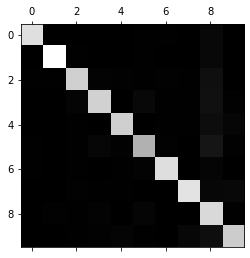

In [72]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can
compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad):

In [73]:
# calculate sum per every column (digit)
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [74]:
# Make a norm conf matrix
norm_conf_mx = conf_mx / row_sums
norm_conf_mx[1]

array([0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
       5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
       3.14446752e-02, 1.48323939e-03])

Remember that rows
represent actual classes, while columns represent predicted classes
Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:

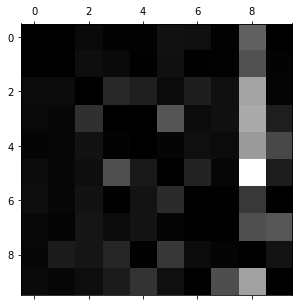

In [75]:
np.fill_diagonal(norm_conf_mx, 0)
fig, ax = plt.subplots(figsize=(5, 5), facecolor="white")
ax.matshow(norm_conf_mx, cmap=plt.cm.gray)

## Multilabel Classification
Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance. For example,
consider a face-recognition classifier: what should it do if it recognizes several
people on the same picture? Of course it should attach one tag per person it recognizes.
Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then
when it is shown a picture of Alice and Charlie, it should output `[1, 0, 1]` (meaning
“Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple
binary tags is called a multilabel classification system.
We won’t go into face recognition just yet, but let’s look at a simpler example, just for
illustration purposes:

In [76]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier(n_jobs=3)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(n_jobs=3)

In [77]:
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right! The digit 5 is indeed not large (False) and odd (True).
There are many ways to evaluate a multilabel classifier, and selecting the right metric
really depends on your project. For example, one approach is to measure the F1 score
for each individual label (or any other binary classifier metric discussed earlier), then
simply compute the average score. This code computes the average $F_1$ score across all
labels:

In [78]:
y_train_knn_predict = cross_val_predict(
    knn_clf, X_train, y_multilabel, cv=3, n_jobs=3)
f1_score(y_multilabel, y_train_knn_predict, average="macro")

0.976410265560605

In [79]:
from sklearn.datasets import fetch_openml

## Multioutput Classification

In [80]:
from sklearn.datasets import fetch_openml

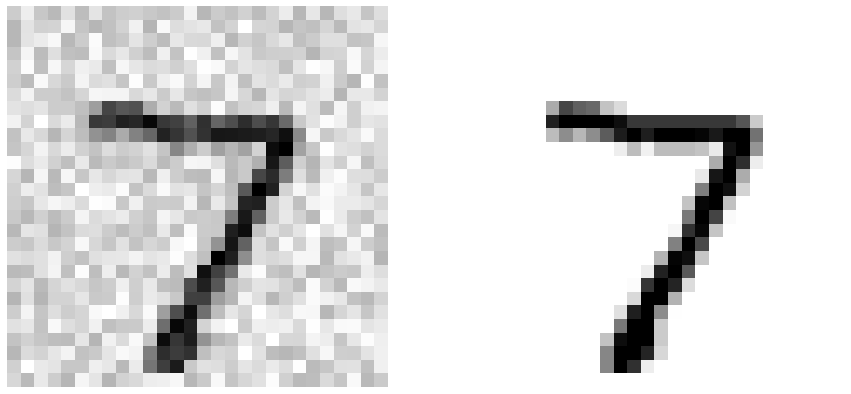

In [81]:
noise = np.random.randint(0, 10, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

some_index = 0

fig, axis = plt.subplots(1, 2, figsize=(15, 15), facecolor='white')

axis[0].imshow(X_test_mod[some_index].reshape(28, 28),
               cmap=mpl.cm.binary)
axis[0].set_axis_off()

axis[1].imshow(y_test_mod[some_index].reshape(28, 28),
               cmap=mpl.cm.binary)
axis[1].set_axis_off()

On the left is the noisy input image, and on the right is the clean target image. Now
let’s train the classifier and make it clean this image:

In [82]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(n_jobs=3)

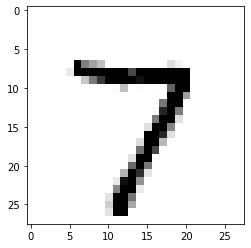

In [83]:
clean_image = knn_clf.predict([X_test_mod[some_index]])
plt.imshow(clean_image.reshape(28, 28),
           cmap=mpl.cm.binary)